In [2]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as tv_models
import json
import os
from torch.utils import data
import torch
import pandas as pd
import numpy as np
import random
from PIL import Image
PHASE_TO_SPLIT = {"training": "TRAIN", "validation": "VAL", "testing": "TEST"}

class SimaseUSVideoDataset(data.Dataset):
    def __init__(self, 
                 phase='training', 
                 transform=None,
                 latents_csv='./', 
                 training_latents_base_path="./", 
                 in_memory=True, 
                 generator_seed=None):
        self.phase = phase
        self.training_latents_base_path = training_latents_base_path

        self.in_memory = in_memory
        self.videos = []

        self.df = pd.read_csv(latents_csv)
        self.df = self.df[self.df["Split"] == PHASE_TO_SPLIT[self.phase]].reset_index(drop=True)

        self.transform = transform

        if generator_seed is None: 
            self.generator = np.random.default_rng() 
            #unseeded
        else:             
            self.generator_seed = generator_seed
            print(f"Set {self.phase} dataset seed to {self.generator_seed}")

        if self.in_memory: 
            self.load_videos()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        vid_a = self.get_vid(index)
        if self.transform is not None:
            vid_a = self.transform(vid_a)
        return vid_a

    def reset_generator(self): 
        self.generator = np.random.default_rng(self.generator_seed) 

    def get_vid(self, index, from_disk=False): 
        if self.in_memory and not from_disk: 
            return self.videos[index]
        else: 
            return torch.load(os.path.join(self.training_latents_base_path, self.df.iloc[index]["FileName"] + ".pt"))

    def load_videos(self): 
        self.videos = []
        print("Preloading videos")
        for i in range(len(self)):
            self.videos.append(self.get_vid(i, from_disk=True))
normalization =lambda x: (x  - x.min())/(x.max() - x.min()) * 2 - 1  # should be -1 to 1 due to way we trained the model


ds_test_dynamic = SimaseUSVideoDataset(phase="testing", transform=normalization, latents_csv="/vol/ideadata/at70emic/projects/TMI23/data/diffusion/dynamic/FileList.csv", training_latents_base_path="/vol/ideadata/at70emic/projects/TMI23/data/diffusion/dynamic/Latents", in_memory=False)
ds_test_psax = SimaseUSVideoDataset(phase="testing", transform=normalization, latents_csv= "/vol/ideadata/at70emic/projects/TMI23/data/diffusion/PSAX/FileList.csv", training_latents_base_path= "/vol/ideadata/at70emic/projects/TMI23/data/diffusion/PSAX/Latents", in_memory=False)
ds_test_a4c = SimaseUSVideoDataset(phase="testing", transform=normalization, latents_csv="/vol/ideadata/at70emic/projects/TMI23/data/diffusion/A4C/FileList.csv", training_latents_base_path= "/vol/ideadata/at70emic/projects/TMI23/data/diffusion/A4C/Latents", in_memory=False)
datasets = {"d": ds_test_dynamic, "p": ds_test_psax, "a": ds_test_a4c}
ds_name_to_name = {"d": "Dynamic", "p": "PSAX", "a": "A4C"}


/vol/ideadata/ed52egek/conda/latecho/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
class SiameseNetwork(nn.Module):
    def __init__(self, network='ResNet-50', in_channels=3, n_features=128):
        super(SiameseNetwork, self).__init__()
        self.network = network
        self.in_channels = in_channels
        self.n_features = n_features

        if self.network == 'ResNet-50':
            # Model: Use ResNet-50 architecture
            self.model = tv_models.resnet50(pretrained=True)
            # Adjust the input layer: either 1 or 3 input channels
            if self.in_channels == 1:
                self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            if self.in_channels == 4: 
                self.model.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            elif self.in_channels == 3:
                pass
            else:
                raise Exception(
                    'Invalid argument: ' + self.in_channels + '\nChoose either in_channels=1 or in_channels=3')
            # Adjust the ResNet classification layer to produce feature vectors of a specific size
            self.model.fc = nn.Linear(in_features=2048, out_features=self.n_features, bias=True)

        else:
            raise Exception('Invalid argument: ' + self.network +
                            '\nChoose ResNet-50! Other architectures are not yet implemented in this framework.')

        self.fc_end = nn.Linear(self.n_features, 1)

    def forward_once(self, x):

        # Forward function for one branch to get the n_features-dim feature vector before merging
        output = self.model(x)
        output = torch.sigmoid(output)
        return output

    def forward(self, input1, input2):

        # Forward
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        # Compute the absolute difference between the n_features-dim feature vectors and pass it to the last FC-Layer
        difference = torch.abs(output1 - output2)
        output = self.fc_end(difference)

        return output


models = {"a": None, "d": None, "p": None}
for model_name, model_ending in zip(["a", "d", "p"], ["a4c", "Dynamic", "psax"]): 
    model_basepath = f"/vol/ideadata/ed52egek/pycharm/privatis_us/archive/{model_ending}LSBest"
    with open(os.path.join(model_basepath, "config.json")) as config:
        config = config.read()

    # parse config
    config = json.loads(config)
    net = SiameseNetwork(network=config['siamese_architecture'], in_channels=config['n_channels'], n_features=config['n_features'])
    net.eval()
    net = net.cuda()
    best_name = [x for x in os.listdir(model_basepath) if x.endswith("best_network.pth")][0]
    net.load_state_dict(torch.load(os.path.join(model_basepath, best_name)))

    models[model_name] = net
    

/vol/ideadata/ed52egek/conda/latecho/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/vol/ideadata/ed52egek/conda/latecho/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/vol/ideadata/ed52egek/conda/latecho/lib/python3.11/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
from tqdm import tqdm
# Enabling LaTeX rendering
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.latex.preamble": r"\usepackage{amsmath}"
})


num_videos = 1000
synth_cnt = 0
real_cnt = 0
video_length = 129
bs = 256

ref_frame = 0  # -1 is synthetic frame

real_cor_timeseries = []
# Plotting synthetic videos
j = 0
ds_name = "d"
ds_train = datasets[ds_name]
corr_matrix_example = None
while real_cnt < num_videos:
    if j >= len(ds_train): 
        print(f"WARNING: Not enough samples found for {ds_name}. Only: {real_cnt}")
        break

    latent_real_video = ds_train[j]
    j+=1
    if len(latent_real_video) < video_length:
        continue

    latent_real_video = latent_real_video[:video_length]
    latents_real = []
    with torch.no_grad():
        for i in np.arange(0, len(latent_real_video), bs):
            batch = latent_real_video[i:i+bs].cuda()
            latents_real.append(net.forward_once(batch))
    latents_real = torch.cat(latents_real)
    train_val_corr_orig = torch.corrcoef(torch.cat([latents_real])).cpu()

    # save first example to plot as heatmap
    if corr_matrix_example is None: 
        corr_matrix_example = torch.clone(train_val_corr_orig)

    train_val_corr_frame = np.delete(train_val_corr_orig[ref_frame], ref_frame)
    real_cor_timeseries.append(train_val_corr_frame)
    real_cnt += 1



0.78719115


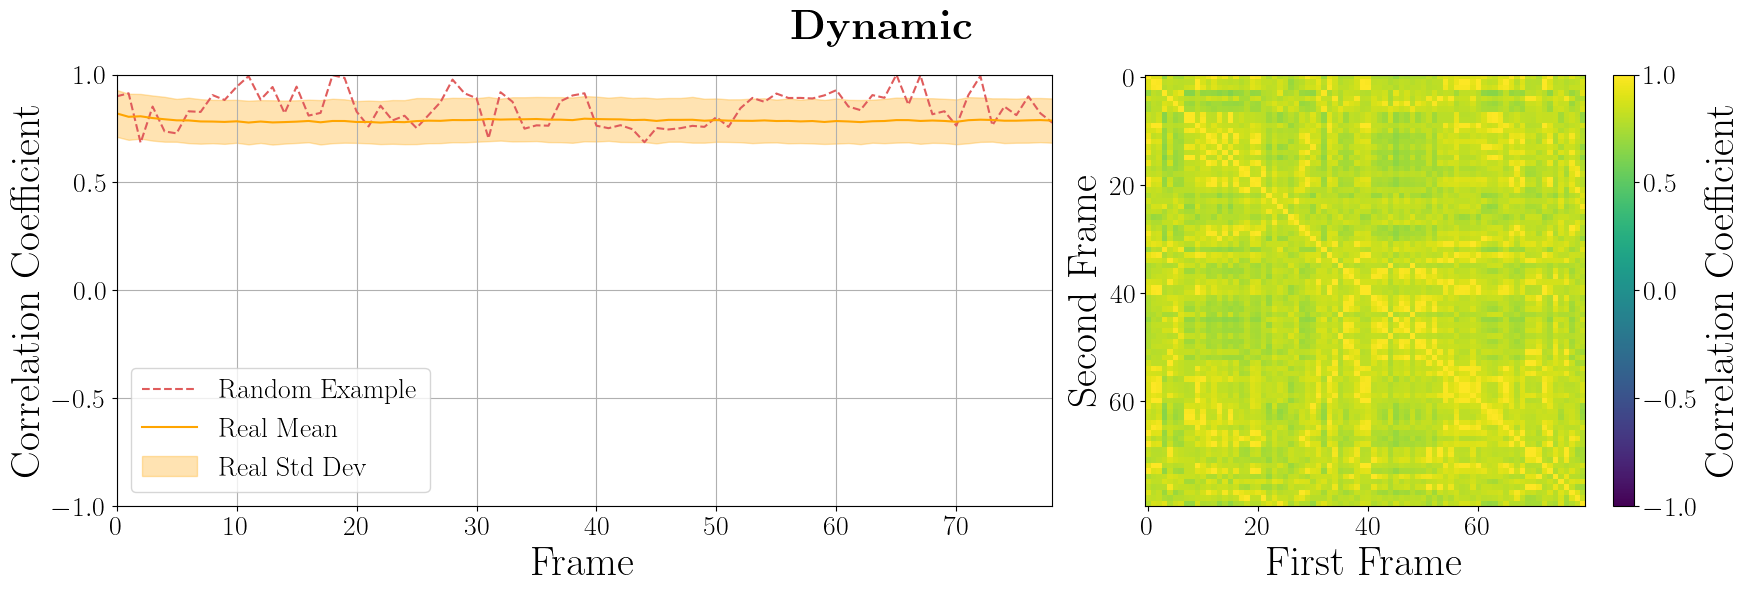

0.78970146


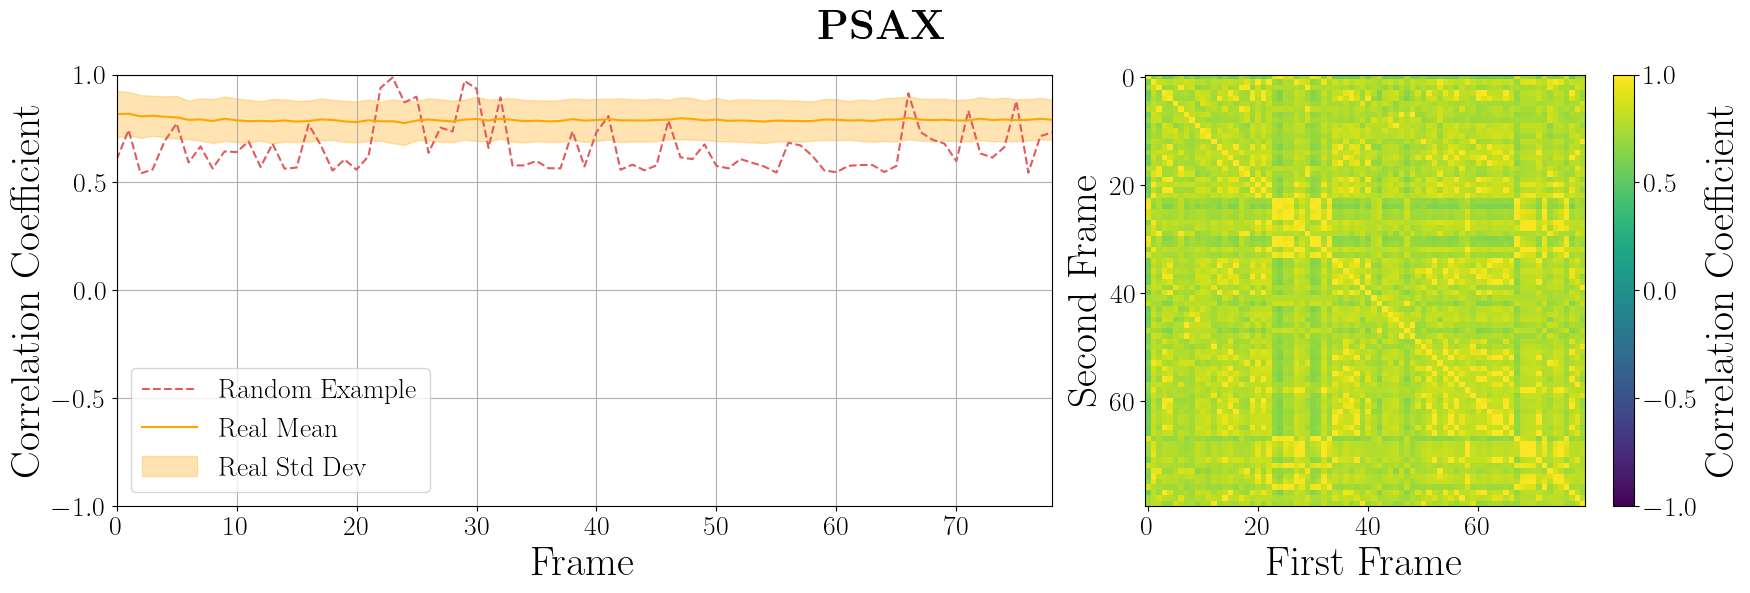

0.7834925


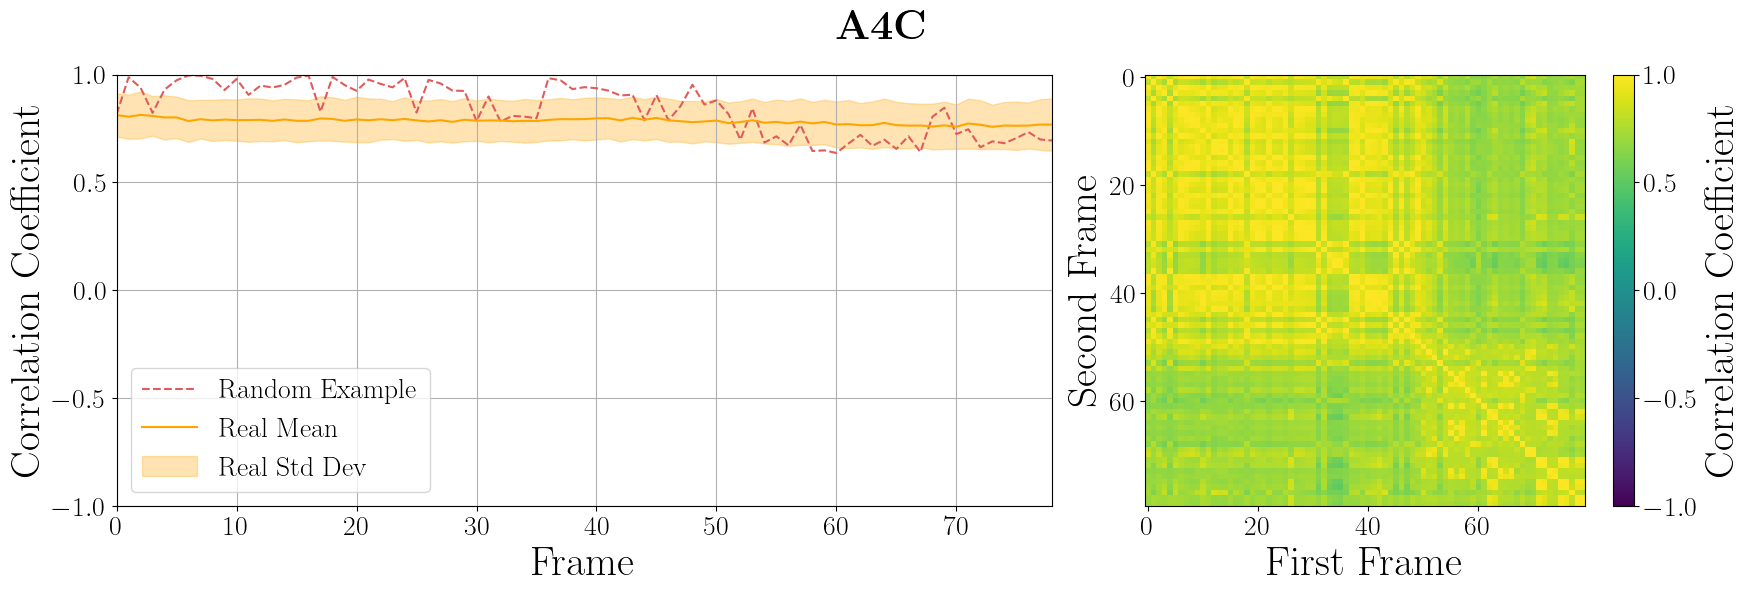

In [7]:
import matplotlib.gridspec as gridspec

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.latex.preamble": r"\usepackage{amsmath}"
})

fs = 30
bs = 256
video_length = 80
num_videos = 1000

for ds_name in datasets.keys():
    synth_cnt = 0
    real_cnt = 0

    ref_frame = 0  # -1 is synthetic frame

    real_cor_timeseries = []
    # Plotting synthetic videos
    j = 0
    ds_train = datasets[ds_name]
    net =  models[model_name]

    corr_matrix_example = None
    while real_cnt < num_videos:
        if j >= len(ds_train): 
            print(f"WARNING: Not enough samples found for {ds_name}. Only: {real_cnt}")
            break

        latent_real_video = ds_train[j]
        j+=1
        if len(latent_real_video) < video_length:
            continue

        latent_real_video = latent_real_video[:video_length]
        latents_real = []
        with torch.no_grad():
            for i in np.arange(0, len(latent_real_video), bs):
                batch = latent_real_video[i:i+bs].cuda()
                latents_real.append(net.forward_once(batch))
        latents_real = torch.cat(latents_real)
        train_val_corr_orig = torch.corrcoef(torch.cat([latents_real])).cpu()

        # save first example to plot as heatmap
        if corr_matrix_example is None: 
            corr_matrix_example = torch.clone(train_val_corr_orig)

        train_val_corr_frame = np.delete(train_val_corr_orig[ref_frame], ref_frame)
        real_cor_timeseries.append(train_val_corr_frame)
        real_cnt += 1

    real_cor_timeseries = np.array(real_cor_timeseries)

    # Compute mean and standard deviation
    real_mean = np.mean(real_cor_timeseries, axis=0)
    print(real_mean.mean())
    real_std = np.std(real_cor_timeseries, axis=0)

    # Time axis (assuming all time series are of the same length)
    time_axis = np.arange(real_mean.shape[0])

    fig = plt.figure(figsize=(18, 6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1.7, 1])

    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])

    ax1.plot(time_axis, real_cor_timeseries[0], linestyle="--", label='Random Example', color="#E05C5C")
    ax1.plot(time_axis, real_mean, label='Real Mean', color='orange')
    ax1.fill_between(time_axis, real_mean - real_std, real_mean + real_std, color='orange', alpha=0.3, label='Real Std Dev')

    # First plot
    ax1.set_ylabel('Correlation Coefficient', fontsize=fs)
    ax1.set_xlabel('Frame', fontsize=fs)
    ax1.set_ylim(-1, 1)
    ax1.set_xlim(0, video_length - 2)
    ax1.grid(True)
    ax1.tick_params(axis='x', labelsize=fs-10)
    ax1.tick_params(axis='y', labelsize=fs-10)
    ax1.legend(fontsize=20)

    # Second plot
    im = ax2.imshow(corr_matrix_example, cmap='viridis', aspect='auto', vmin=-1, vmax=1)


    # Add a colorbar to the second plot
    cbar = fig.colorbar(im, ax=ax2)
    cbar.set_label('Correlation Coefficient', fontsize=fs)
    cbar.ax.tick_params(labelsize=fs-10)

    # Label the x-axis and y-axis of the second plot
    ax2.set_xlabel('First Frame', fontsize=fs)
    ax2.set_ylabel('Second Frame', fontsize=fs)
    ax2.tick_params(axis='x', labelsize=fs-10)
    ax2.tick_params(axis='y', labelsize=fs-10)

    ds_str = ds_name_to_name[ds_name] 
    fig.suptitle(r'\textbf{' + ds_str + r'}', fontsize=fs)
    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(f"combined_figure_{ds_name_to_name[ds_name]}.pdf", dpi=600)
    plt.show()